In [1]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
#building the environment
class Environment:
    def __init__(self, M,N, holes, terminal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.shape = (M,N)
        self.holes = holes
        self.terminal_state = terminal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
        self.prob_agent_action = [0.8, 0.1, 0.05, 0.05]
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state == (6,3):
                r[state] = -15
            elif state == (6,6):
                r[state] = 15
            else:
                r[state] = 0
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner_and_hole((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'
    
    def check_corner_and_hole(self, s): 
        #function to check if the updates state goes out of the gridworld or goes into holes. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        x1, y1 = s
        stay_same = False
        for hole in self.holes:
            if (x1,y1) == hole:
                stay_same = True

        if x1<1 or x1>6:
            stay_same = True
        if y1<1 or y1>6:
            stay_same = True
        
        return stay_same
    
    
            

In [3]:
gridworld = Environment(6,6, [(4,3),(5,3)], (6,6))


In [7]:
#building the cross entropy method agent
class CEM:
    #initializing the agent parameters
    def __init__(self, gamma, env , K0 = 500, epsilon = 0.25):
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.K = K0
        self.param_dim = len(env.states) * len(self.actions)
        self.param_mean = [10] * self.param_dim
        self.param_cov = 5*np.identity(self.param_dim)
        
        self.epsilon = epsilon
        self.initialize_theta(env)
#         self.V = self.initialize_value_states(env)
#         self.Q = self.initialize_Qvalue(env)
    
    def initialize_theta(self,env):
        #function to intialize K thetas where each theta is sampled from a multivariate gaussian
        self.state2param = {}
        self.param2state = {}
        i = 0
        for s in env.states:
            for a in self.actions:
                self.state2param[(s,a)] = i
                self.param2state[i] = (s,a)
                i+=1
        
        self.thetas = np.random.multivariate_normal(self.param_mean, self.param_cov, size = self.K)
        self.pi = self.find_policy(self.param_mean, env)
        #print (self.thetas.shape)
        
    def possible_actions(self, s, pi):
        #function to return the possible actions given a state s and policy pi
        actions = [a for a in pi[s]]
        return actions
            
    def initialize_Qvalue(self, env):
        #function to initialize Q values
        Q = {}
        for s in env.states:
            Q[s] = {}
            for a in self.actions:
                Q[s][a] = 0
                
        return Q
    
    def initialize_value_states(self, env):
        #function to inititalize value of states
        v_s = {}
        for state in env.states:
            v_s[state] = 0
            
        return v_s
    
    def find_policy(self,theta1,env):
        #function to find the policy corresponding to a given theta which is a vector of parameters of size 136 (=34*4)
        pi = {}
        for s in env.states:
            pi[s] = {}
        
        for i in range(self.param_dim):
            s,a = self.param2state[i]
            theta = theta1[i]
            pi[s][a] = theta
            
            
        for s in env.states:
            prob_sum = 0
            for a in self.actions:
                p = np.exp(pi[s][a])
                prob_sum+=p
                pi[s][a] = p
                
            for a in self.actions:
                pi[s][a] /= prob_sum
            
            
        return pi
                
            
    
    def compute_value(self, env, pi, epsilon = 1e-8):
        #function to evaluate the policy pi 
        delta = np.inf
        Q = {}
        V = {}
        for s in env.states:
            Q[s] = {}
            if s==env.terminal_state:
                V[s] = 15
            else:
                V[s] = random.random()
                
            for a in self.actions:
                Q[s][a] = 0
                
        while delta > epsilon:
            max_diff = -np.inf
            for s in env.states:
                if s!=env.terminal_state:
                    v = 0
                    for a in pi[s]:
                        p = pi[s][a]
                        #with prob 0.8 take action a to get to state s1 with reward r1
                        s1 = env.agent_move(s,a)
                        r1 = env.rewards[s1]

                        v1 = 0.8 * (r1 + self.gamma*V[s1])

                        #with prob 0.1 stay in same state s
                        r2 = env.rewards[s]
                        v2 = 0.1 * (r2 + self.gamma * V[s])

                        #with prob 0.05 take action in direction +90 degree clockwise direction
                        a3 = env.move_clockwise90(a)
                        s3 = env.agent_move(s, a3)
                        r3 = env.rewards[s3]
                        v3 = 0.05 * (r3 + self.gamma * V[s3])

                        #with prob 0.05 take action in direction -90 degree clockwise direction

                        a4 = env.move_anti_clockwise90(a)
                        s4 = env.agent_move(s, a4)
                        r4 = env.rewards[s4]
                        v4 = 0.05 * (r4 + self.gamma * V[s4])

                        v = v + (p * (v1+v2+v3+v4))
                        Q[s][a] = v1+v2+v3+v4

                    diff = abs(V[s] - v)
                    V[s] = v
                    max_diff = max(max_diff, diff)
                
            delta = max_diff
            
        return V,Q
    
    def param_update(self, env, keep_pct = 0.9):
        #function to update parameters of the cross entropy method
        
        #the new K value will be maximum of 90% of current K value and 80
        K_new = max(np.int(keep_pct*self.K),80)
        values = []
        max_s11_value = -np.inf
        
        #for each theta, find policy corresponding to it and evaluate the Q values
        Qs = []
        for i in range(self.K):
            theta_i = self.thetas[i,:]
            pi = self.find_policy(theta_i, env)
            V,Q = self.compute_value(env, pi)
            Qs.append(Q)
            s11_value = V[(1,1)]
            #tot_val = self.compute_total_state_value(V, env)
            
            if s11_value > max_s11_value:
                max_s11_value = s11_value
                self.best_theta = theta_i
            
            values.append(s11_value)
        
#         best_indices = np.argsort(values)[-K_new:]
#         thetas = self.thetas[best_indices,]
        
        #for each parameter of theta corressponding to a state action pair choose K_new theta values which has the best Q values
        thetas = []
        for i in range(self.param_dim):
            s,a = self.param2state[i]
            qsa_values = [q[s][a] for q in Qs]
            best_indices = np.argsort(qsa_values)[-K_new:]
            theta_sa_new = list(self.thetas[best_indices,i])
            thetas.append(theta_sa_new)
        
        thetas = np.array(thetas).T
        
        #self.param_mean, self.param_cov = self.update_mean_and_cov(thetas)
        
        #Update mean and covariance vector of theta based on these new K values
        self.param_mean = np.mean(thetas, axis = 0)
        self.param_cov = np.cov(thetas.T)
        
        self.K = K_new  
        
        # Sample a new K theta values based on updated parameters
        self.thetas = np.random.multivariate_normal(self.param_mean, self.param_cov, size = self.K)
        self.pi = self.find_policy(self.param_mean, env)
        
        #print (max_s11_value)
        return max_s11_value
    
    def play(self, env, iterations = 100):
        #function to play the cross entropy method over 100 iterations
        v_s11 = []
        for iteration in tqdm(range(iterations)):
            s11 = self.param_update(env)
            if iteration==(iterations-1):
                self.pi = self.find_policy(self.best_theta, env)
            
            v_s11.append(s11)        
        
        return v_s11
         
    def find_optimal_move(self, s):
        #function to find the optimal move given the policy
        optimal_moves = []
        max_v = 0
        for a in self.pi[s]:
            if self.pi[s][a] > max_v:
                optimal_moves = [a]
                max_v = self.pi[s][a]
            elif self.pi[s][a] == max_v:
                optimal_moves.append(a)
                
        return optimal_moves
    
            
    def plot_state_and_policy(self, env, plot_state_values = False, label = None):
        #function to plot state values and policy
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                    if plot_state_values:
                        t = round(self.V[s], 3)
                        value = str(s) + "\n\n" + str(t) + "\n\n" + "TERMINAL"
                    else:
                        value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_optimal_move(s)
                    if plot_state_values==False:
                        value = value + '\n\n' + ','.join(move)
                    else:
                        t = round(self.V[s],3)
                        value = value + '\n\n' + str(t)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])
        if label is not None:
            plt.savefig(label)   
                

In [8]:
agent = CEM(0.9, gridworld)

In [9]:
values = agent.play(gridworld)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:37<00:00, 10.57s/it]


Plot of values of state (1,1) across iterations of Cross entropy method

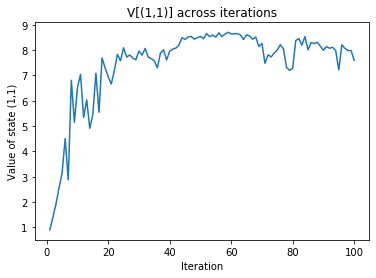

In [10]:
def plot_values(values,label = None):
        ts = np.arange(1,(len(values)+1))
        plt.plot(ts, values)
        plt.xlabel("Iteration")
        plt.ylabel("Value of state (1,1)")
        plt.title("V[(1,1)] across iterations")
        if label is not None:
            plt.savefig(label)
        plt.show()
        
plot_values(values, label = 'plots/1_c_value_state_across_iterations.png')

Plot of policy learnt by the cross entropy method

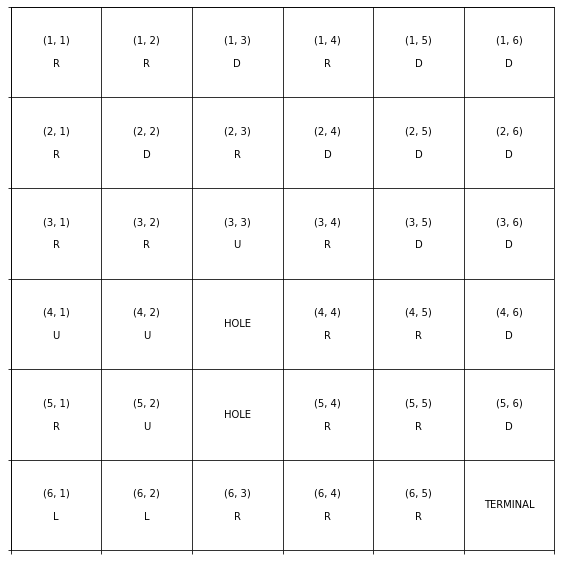

In [12]:
agent.plot_state_and_policy(gridworld, label = 'plots/1_c_optimal_policy.png')